In [1]:
# General
import os
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 7)  # make the default figure size larger
matplotlib.rcParams['image.interpolation'] = 'nearest'  # don't blur/smooth image plots

# PSF - STAR direct
import webbpsf
import webbpsf.roman

# Gaussian - GALAXY direct
from astropy.modeling.functional_models import Gaussian2D as gauss

# pysynphot - work with spectra
import pysynphot as S
import synphot

# Astropy - read files
from astropy.io import fits
from astropy.table import Table

# Grizli - sim
from grizli.model import GrismFLT

# Progress bar
from tqdm import tqdm
from IPython.display import clear_output

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# Name all relevant files & load in catalog
direct_file = "ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = "empty_seg.fits"
empty_direct = "empty_direct.fits"

hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format="ascii")
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

# # While testing and imporving sim, I'm only using a small cutout
# x_pos = 2124
# y_pos = 1223
# size = 500
# cutout_condition = (abs(hlss_tbl["X_IMAGE"] - x_pos) < size) & (abs(hlss_tbl["Y_IMAGE"] - y_pos) < size)
# cutout_tbl = hlss_tbl[np.where(cutout_condition)]

# cutout_tbl = cutout_tbl.group_by("MODIMAGE")

In [3]:
# Generate and Save an empty segmentation fits and direct fits
zero_data = np.zeros((4088,4088))

# Take header info from prepared direct image
file = fits.open(direct_file)
phdu = file[0]
hdr = file[1].header

# Structure empty direct fits
ihdu = fits.ImageHDU(data=zero_data, header=hdr, name="SCI")
errhdu = fits.ImageHDU(data=zero_data, header=hdr, name="ERR")
dqhdu = fits.ImageHDU(data=zero_data, header=hdr, name="DQ")
hdul = [phdu, ihdu, errhdu, dqhdu]

# Save both files
fits.HDUList(hdul).writeto(empty_direct, overwrite=True)
fits.writeto(empty_seg, data=zero_data, header=hdr, overwrite=True)

# I/O and cleaning
file.close()
del phdu
del hdr
del ihdu
del errhdu
del dqhdu
del hdul

# No longer deleting zero_data variable; used to save zero ERR and DQ FITS extensions later

In [4]:
# Semi-function amplitude and mag-normed count functions
f158_lam_center = 1.577 * 10**-6 # meter
telarea = 2.36**2 * constants.pi # meter ** 2

# theoretically, this is comparable to an ABZeropoint
f_0 = 3.7059108273831045e-10 # this is just a number that seems to get close to expected values in testing

# Calculate number of counts as a function of magnitude
N = lambda mag: telarea * (f158_lam_center / (constants.h * constants.speed_of_light)) * f_0 * 10**(-0.4 * mag)

# Calculate 2D Gassian amplitude as a function of galaxy shape and magnitude
amplitude_func = lambda x_stddev, y_stddev, mag: N(mag) / (2 * constants.pi * x_stddev * y_stddev)

In [5]:
# Instantiate Grizli
pad = 100
roman_sim = GrismFLT(direct_file=empty_direct, seg_file=empty_seg, pad=pad)

# Instantiate WebbPSF
wfi = webbpsf.roman.WFI()
wfi.filter = "GRISM0"

# Instantiate empty segmentation map and direct image; for troubleshooting
# This will be filled with every iteration so you can see at the end what Grizli had to work with
full_seg = np.zeros((4088, 4088))
full_direct = np.zeros((4088, 4088))



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [6]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Read in star spectrum
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii", descriptions=["wavelength", "flux"])
star_spec = S.ArraySpectrum(wave=df["col1"], flux=df["col2"], waveunits="angstrom", fluxunits="flam")
src = {"wavelengths": star_spec.wave, "weights": star_spec.flux / star_spec.flux.sum()}

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

error_file = open("errors.txt", "w")

for object in tqdm(hlss_tbl):

    # DIRECT SIMULATION --------------------------

    # Take object info
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]
    modimage = object["MODIMAGE"]

    # STAR
    if modimage:
        x_0 = round(x_0)
        y_0 = round(y_0)
        # Produce PSF Image at detector position
        wfi.detector_position = (x_0 + 4, y_0 + 4) # WebbPSF include 4 rows of dark pixels
        psf = wfi.calc_psf(normalize='last', fov_pixels=182, oversample=2)

        # Multiply PSF by magnitude-normalized photon count
        total_photon_count = N(mag)
        psf[0].data *= total_photon_count

        # Place PSF in direct image
        dir_array = np.zeros((4088,4088)) # empty array

        det_xmin = max(0, x_0 - 182)       # Where is the PSF on the detector; limit by detector bounds
        det_xmax = min(4088, x_0 + 182)
        det_ymin = max(0, y_0 - 182)
        det_ymax = min(4088, y_0 + 182)

        psf_xmin = max(0, 182 - x_0)        # Take only the PSF on the detector
        psf_xmax = min(364, 182 + 4088 - x_0)
        psf_ymin = max(0, 182 - y_0)
        psf_ymax = min(364, 182 + 4088 - y_0)

        dir_array[det_ymin:det_ymax, det_xmin:det_xmax] = psf[0].data[psf_ymin:psf_ymax, psf_xmin:psf_xmax]
        roman_sim.direct.data["SCI"] = np.rot90(dir_array, k=3).astype("float32")
        full_direct += np.rot90(dir_array, k=3).astype("float32")

    # GALAXY
    else:
        x_mean = y_0 # x and y are flipped in Gaussian2D function
        y_mean = x_0 # x and y are flipped in Gaussian2D function
        x_stddev = object["B_IMAGE"] # Semi-minor is x-axis per testing
        y_stddev = object["A_IMAGE"] # Semi-major is y-axis per testing
        theta = object["THETA_IMAGE"] * (constants.pi / 180) # Counterclockwise rotation; radians

        # Calculate 2D Gaussian amplitude/max value
        amplitude = amplitude_func(x_stddev, y_stddev, mag)
        args = (amplitude, x_mean, y_mean, x_stddev, y_stddev, theta) # store args for readability

        # Create direct object image
        dir_array = np.fromfunction(lambda i,j: gauss.evaluate(i, j, *args), shape=(4088,4088))

        # Store temp_direct; Rotated for dispersion in right direction
        roman_sim.direct.data["SCI"] = np.rot90(dir_array, k=3).astype("float32")
        full_direct += np.rot90(dir_array, k=3).astype("float32")

    # SEGMENTATION -------------------------------

    # Empty temp_seg every time
    temp_seg = np.zeros((4088,4088), dtype="float32")
    
    # Anywhere temp_direct isn't zero is our object; NOTE: DIRECT IMAGE ALREADY ROTATED; DO NOT ROTATE AGAIN HERE
    # Using slice method for stars to speed up slightly
    if modimage:
        condition = (roman_sim.direct.data["SCI"] != 0)
        temp_seg[np.where(condition)] = id
    else:
        condition = (roman_sim.direct.data["SCI"] != 0)
        temp_seg[np.where(condition)] = id 

    # Write objects too small to land on seg in seperate file
    if not np.any(temp_seg):
        error_file.write("ID {0} not in temp_seg \n".format(id))
        continue

    # Store temp_seg
    roman_sim.seg = temp_seg
    full_seg += temp_seg

    # GRISM SIMULATION ---------------------------

    # STAR
    if modimage:
        # Renorm STAR spectrum with bandpass and magnitude, convert back to cgs units
        spec = star_spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    # GALAXY
    else:
        # Load GALAXY SED
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(object["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object['Z']

        # Create Spectrum object, redshift, normalize with bandpass, convert back to cgs units
        spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
        spec = spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

  1%|▏         | 138/10763 [00:31<40:31,  4.37it/s]

ID 136415 not found in segmentation image


  2%|▏         | 238/10763 [00:55<40:37,  4.32it/s]

ID 74258 not found in segmentation image


  2%|▏         | 241/10763 [00:55<40:51,  4.29it/s]

ID 65012 not found in segmentation image


  2%|▏         | 244/10763 [00:56<41:15,  4.25it/s]

ID 94017 not found in segmentation image


  3%|▎         | 270/10763 [01:02<40:57,  4.27it/s]

ID 104592 not found in segmentation image


  3%|▎         | 316/10763 [01:13<40:46,  4.27it/s]

ID 147220 not found in segmentation image


  4%|▎         | 403/10763 [01:33<40:22,  4.28it/s]

ID 40815 not found in segmentation image


  4%|▍         | 413/10763 [01:36<40:35,  4.25it/s]

ID 63865 not found in segmentation image


  5%|▍         | 508/10763 [01:58<40:14,  4.25it/s]

ID 68195 not found in segmentation image


  5%|▍         | 534/10763 [02:04<40:30,  4.21it/s]

ID 19068 not found in segmentation image


  6%|▌         | 649/10763 [02:31<39:23,  4.28it/s]

ID 855 not found in segmentation image


  8%|▊         | 813/10763 [03:11<39:03,  4.25it/s]

ID 60547 not found in segmentation image


  9%|▉         | 1002/10763 [03:56<38:17,  4.25it/s]

ID 154952 not found in segmentation image


 10%|▉         | 1065/10763 [04:11<39:12,  4.12it/s]

ID 74424 not found in segmentation image


 10%|▉         | 1076/10763 [04:13<38:07,  4.23it/s]

ID 101642 not found in segmentation image


 10%|█         | 1120/10763 [04:24<39:02,  4.12it/s]

ID 64248 not found in segmentation image


 11%|█         | 1190/10763 [04:41<38:32,  4.14it/s]

ID 187390 not found in segmentation image


 12%|█▏        | 1264/10763 [04:59<38:45,  4.08it/s]

ID 155974 not found in segmentation image


 12%|█▏        | 1343/10763 [05:18<37:25,  4.19it/s]

ID 194116 not found in segmentation image


 13%|█▎        | 1379/10763 [05:26<37:05,  4.22it/s]

ID 170524 not found in segmentation image


 13%|█▎        | 1387/10763 [05:28<37:03,  4.22it/s]

ID 136420 not found in segmentation image


 14%|█▍        | 1480/10763 [05:50<37:20,  4.14it/s]

ID 40762 not found in segmentation image


 14%|█▍        | 1531/10763 [06:03<37:15,  4.13it/s]

ID 124920 not found in segmentation image


 14%|█▍        | 1537/10763 [06:04<37:04,  4.15it/s]

ID 4 not found in segmentation image


 16%|█▌        | 1715/10763 [06:46<34:46,  4.34it/s]

ID 114057 not found in segmentation image


 16%|█▌        | 1737/10763 [06:51<34:39,  4.34it/s]

ID 55810 not found in segmentation image


 16%|█▋        | 1765/10763 [06:58<36:47,  4.08it/s]

ID 117933 not found in segmentation image


 18%|█▊        | 1939/10763 [07:40<35:07,  4.19it/s]

ID 22851 not found in segmentation image


 18%|█▊        | 1943/10763 [07:41<35:23,  4.15it/s]

ID 136421 not found in segmentation image


 18%|█▊        | 1987/10763 [07:51<36:00,  4.06it/s]

ID 145031 not found in segmentation image


 20%|██        | 2164/10763 [08:34<34:23,  4.17it/s]

ID 147230 not found in segmentation image


 21%|██        | 2219/10763 [08:48<33:20,  4.27it/s]

ID 36577 not found in segmentation image


 21%|██▏       | 2291/10763 [09:05<33:10,  4.26it/s]

ID 165064 not found in segmentation image


 21%|██▏       | 2306/10763 [09:08<32:35,  4.33it/s]

ID 902 not found in segmentation image


 22%|██▏       | 2336/10763 [09:15<32:31,  4.32it/s]

ID 153878 not found in segmentation image


 22%|██▏       | 2393/10763 [09:29<33:10,  4.21it/s]

ID 118984 not found in segmentation image


 24%|██▎       | 2535/10763 [10:03<32:51,  4.17it/s]

ID 1443 not found in segmentation image


 25%|██▍       | 2640/10763 [10:28<31:29,  4.30it/s]

ID 115539 not found in segmentation image


 25%|██▍       | 2643/10763 [10:29<31:59,  4.23it/s]

ID 20614 not found in segmentation image


 25%|██▌       | 2698/10763 [10:41<31:51,  4.22it/s]

ID 102979 not found in segmentation image


 26%|██▌       | 2748/10763 [10:53<31:05,  4.30it/s]

ID 11658 not found in segmentation image


 28%|██▊       | 3011/10763 [11:55<30:06,  4.29it/s]

ID 41786 not found in segmentation image


 29%|██▉       | 3111/10763 [12:18<30:36,  4.17it/s]

ID 120042 not found in segmentation image


 29%|██▉       | 3113/10763 [12:19<31:29,  4.05it/s]

ID 96886 not found in segmentation image


 29%|██▉       | 3171/10763 [12:33<30:19,  4.17it/s]

ID 19735 not found in segmentation image


 30%|███       | 3271/10763 [12:56<29:06,  4.29it/s]

ID 75977 not found in segmentation image


 31%|███▏      | 3372/10763 [13:20<30:48,  4.00it/s]

ID 187609 not found in segmentation image


 33%|███▎      | 3542/10763 [14:00<28:36,  4.21it/s]

ID 102075 not found in segmentation image


 33%|███▎      | 3549/10763 [14:02<27:58,  4.30it/s]

ID 59380 not found in segmentation image


 35%|███▍      | 3715/10763 [14:41<28:15,  4.16it/s]

ID 147658 not found in segmentation image


 36%|███▌      | 3833/10763 [15:09<26:49,  4.31it/s]

ID 174379 not found in segmentation image


 37%|███▋      | 3989/10763 [15:47<26:47,  4.21it/s]

ID 80484 not found in segmentation image


 37%|███▋      | 4011/10763 [15:52<26:29,  4.25it/s]

ID 116417 not found in segmentation image


 38%|███▊      | 4103/10763 [16:14<26:08,  4.25it/s]

ID 96254 not found in segmentation image


 39%|███▉      | 4231/10763 [16:45<26:04,  4.17it/s]

ID 194299 not found in segmentation image


 40%|████      | 4356/10763 [17:16<27:27,  3.89it/s]

ID 115677 not found in segmentation image


 41%|████      | 4427/10763 [17:33<25:39,  4.12it/s]

ID 138019 not found in segmentation image


 42%|████▏     | 4561/10763 [18:04<24:33,  4.21it/s]

ID 96740 not found in segmentation image


 42%|████▏     | 4574/10763 [18:08<24:26,  4.22it/s]

ID 68097 not found in segmentation image


 45%|████▍     | 4804/10763 [19:03<24:13,  4.10it/s]

ID 173798 not found in segmentation image


 45%|████▍     | 4835/10763 [19:10<23:34,  4.19it/s]

ID 139278 not found in segmentation image


 46%|████▌     | 4905/10763 [19:27<22:54,  4.26it/s]

ID 176355 not found in segmentation image


 47%|████▋     | 5009/10763 [19:52<22:50,  4.20it/s]

ID 68087 not found in segmentation image


 47%|████▋     | 5045/10763 [20:01<23:31,  4.05it/s]

ID 112640 not found in segmentation image


 47%|████▋     | 5089/10763 [20:12<22:05,  4.28it/s]

ID 189658 not found in segmentation image


 47%|████▋     | 5101/10763 [20:14<21:51,  4.32it/s]

ID 117592 not found in segmentation image


 50%|████▉     | 5346/10763 [21:12<20:54,  4.32it/s]

ID 83457 not found in segmentation image


 51%|█████     | 5457/10763 [21:38<20:43,  4.27it/s]

ID 39776 not found in segmentation image


 52%|█████▏    | 5543/10763 [21:59<20:17,  4.29it/s]

ID 69480 not found in segmentation image


 52%|█████▏    | 5554/10763 [22:01<20:08,  4.31it/s]

ID 12140 not found in segmentation image


 53%|█████▎    | 5678/10763 [22:30<20:21,  4.16it/s]

ID 166527 not found in segmentation image


 54%|█████▎    | 5785/10763 [22:56<19:44,  4.20it/s]

ID 190832 not found in segmentation image


 54%|█████▍    | 5790/10763 [22:57<19:29,  4.25it/s]

ID 548 not found in segmentation image


 54%|█████▍    | 5851/10763 [23:12<19:32,  4.19it/s]

ID 155142 not found in segmentation image


 57%|█████▋    | 6168/10763 [24:29<18:41,  4.10it/s]

ID 112513 not found in segmentation image


 61%|██████    | 6530/10763 [25:57<17:06,  4.12it/s]

ID 114388 not found in segmentation image


 62%|██████▏   | 6675/10763 [26:31<16:39,  4.09it/s]

ID 143077 not found in segmentation image


 62%|██████▏   | 6716/10763 [26:41<16:05,  4.19it/s]

ID 180657 not found in segmentation image


 64%|██████▍   | 6878/10763 [27:19<14:59,  4.32it/s]

ID 103017 not found in segmentation image


 67%|██████▋   | 7179/10763 [28:30<13:52,  4.30it/s]

ID 156744 not found in segmentation image


 68%|██████▊   | 7314/10763 [29:02<14:00,  4.10it/s]

ID 96885 not found in segmentation image


 68%|██████▊   | 7320/10763 [29:04<13:39,  4.20it/s]

ID 195034 not found in segmentation image


 69%|██████▉   | 7418/10763 [29:27<13:19,  4.18it/s]

ID 178686 not found in segmentation image


 70%|██████▉   | 7522/10763 [29:52<13:08,  4.11it/s]

ID 79259 not found in segmentation image


 71%|███████   | 7628/10763 [30:18<12:30,  4.18it/s]

ID 83534 not found in segmentation image


 72%|███████▏  | 7790/10763 [30:57<11:31,  4.30it/s]

ID 63062 not found in segmentation image


 73%|███████▎  | 7865/10763 [31:15<12:18,  3.93it/s]

ID 169422 not found in segmentation image


 74%|███████▍  | 7995/10763 [31:46<11:14,  4.10it/s]

ID 68086 not found in segmentation image


 77%|███████▋  | 8240/10763 [32:44<09:48,  4.28it/s]

ID 172146 not found in segmentation image


 77%|███████▋  | 8250/10763 [32:46<09:41,  4.32it/s]

ID 68088 not found in segmentation image


 77%|███████▋  | 8334/10763 [33:06<10:25,  3.88it/s]

ID 18396 not found in segmentation image


 78%|███████▊  | 8410/10763 [33:25<09:12,  4.26it/s]

ID 111170 not found in segmentation image


 80%|███████▉  | 8581/10763 [34:05<08:39,  4.20it/s]

ID 129233 not found in segmentation image


 80%|████████  | 8632/10763 [34:18<08:33,  4.15it/s]

ID 102085 not found in segmentation image


 82%|████████▏ | 8857/10763 [35:12<07:30,  4.24it/s]

ID 61981 not found in segmentation image


 83%|████████▎ | 8884/10763 [35:18<07:32,  4.16it/s]

ID 125905 not found in segmentation image


 83%|████████▎ | 8889/10763 [35:19<07:27,  4.19it/s]

ID 147222 not found in segmentation image


 84%|████████▍ | 9021/10763 [35:51<06:55,  4.19it/s]

ID 69477 not found in segmentation image


 84%|████████▍ | 9064/10763 [36:02<06:35,  4.29it/s]

ID 180465 not found in segmentation image


 85%|████████▍ | 9099/10763 [36:10<06:37,  4.19it/s]

ID 169423 not found in segmentation image


 85%|████████▍ | 9134/10763 [36:18<06:30,  4.17it/s]

ID 147234 not found in segmentation image


 85%|████████▌ | 9161/10763 [36:25<06:26,  4.14it/s]

ID 102957 not found in segmentation image


 86%|████████▌ | 9218/10763 [36:39<06:02,  4.26it/s]

ID 134473 not found in segmentation image


 87%|████████▋ | 9383/10763 [37:19<05:31,  4.17it/s]

ID 177782 not found in segmentation image


 87%|████████▋ | 9406/10763 [37:24<05:23,  4.20it/s]

ID 147223 not found in segmentation image


 88%|████████▊ | 9449/10763 [37:34<05:30,  3.98it/s]

ID 59885 not found in segmentation image


 88%|████████▊ | 9486/10763 [37:43<05:00,  4.26it/s]

ID 102978 not found in segmentation image


 89%|████████▉ | 9614/10763 [38:13<04:27,  4.29it/s]

ID 62056 not found in segmentation image


 89%|████████▉ | 9629/10763 [38:17<04:27,  4.25it/s]

ID 137936 not found in segmentation image


 92%|█████████▏| 9856/10763 [39:10<03:29,  4.32it/s]

ID 102072 not found in segmentation image


 93%|█████████▎| 10030/10763 [39:52<03:01,  4.03it/s]

ID 116799 not found in segmentation image


 94%|█████████▍| 10136/10763 [40:18<02:42,  3.87it/s]Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053

ID 208537 not found in segmentation image


 95%|█████████▍| 10196/10763 [44:01<34:09,  3.61s/it]Attempted to get aberrations at field point (871, 3977) which is outside the range of the reference data; approximating to nearest interpolated point (870.5772108384864, 3551.145617065437)
Attempted to get aberrations at field point (871, 3977) which is outside the range of the reference data; approximating to nearest interpolated point (870.5772108384864, 3551.145617065437)
Attempted to get aberrations at field point (871, 3977) which is outside the range of the reference data; approximating to nearest interpolated point (870.5772108384864, 3551.145617065437)
Attempted to get aberrations at field point (871, 3977) which is outside the range of the reference data; approximating to nearest interpolated point (870.5772108384864, 3551.145617065437)
Attempted to get aberrations at field point (871, 3977) which is outside the range of the reference data; approximating to nearest interpolated point (870.5772108384864, 3551.145617065437)
At

ID 208508 not found in segmentation image


 95%|█████████▍| 10199/10763 [44:12<34:43,  3.69s/it]Attempted to get aberrations at field point (928, 3968) which is outside the range of the reference data; approximating to nearest interpolated point (927.58608986699, 3551.089018525821)
Attempted to get aberrations at field point (928, 3968) which is outside the range of the reference data; approximating to nearest interpolated point (927.58608986699, 3551.089018525821)
Attempted to get aberrations at field point (928, 3968) which is outside the range of the reference data; approximating to nearest interpolated point (927.58608986699, 3551.089018525821)
Attempted to get aberrations at field point (928, 3968) which is outside the range of the reference data; approximating to nearest interpolated point (927.58608986699, 3551.089018525821)
Attempted to get aberrations at field point (928, 3968) which is outside the range of the reference data; approximating to nearest interpolated point (927.58608986699, 3551.089018525821)
Attempted to

ID 208463 not found in segmentation image


 95%|█████████▍| 10218/10763 [45:28<36:35,  4.03s/it]Attempted to get aberrations at field point (209, 3724) which is outside the range of the reference data; approximating to nearest interpolated point (208.82904204725023, 3551.80260209278)
Attempted to get aberrations at field point (209, 3724) which is outside the range of the reference data; approximating to nearest interpolated point (208.82904204725023, 3551.80260209278)
Attempted to get aberrations at field point (209, 3724) which is outside the range of the reference data; approximating to nearest interpolated point (208.82904204725023, 3551.80260209278)
Attempted to get aberrations at field point (209, 3724) which is outside the range of the reference data; approximating to nearest interpolated point (208.82904204725023, 3551.80260209278)
Attempted to get aberrations at field point (209, 3724) which is outside the range of the reference data; approximating to nearest interpolated point (208.82904204725023, 3551.80260209278)
At

ID 209096 not found in segmentation image


 95%|█████████▌| 10229/10763 [46:13<36:16,  4.07s/it]Attempted to get aberrations at field point (3139, 4090) which is outside the range of the reference data; approximating to nearest interpolated point (3138.4627888362475, 3548.894055310165)
Attempted to get aberrations at field point (3139, 4090) which is outside the range of the reference data; approximating to nearest interpolated point (3138.4627888362475, 3548.894055310165)
Attempted to get aberrations at field point (3139, 4090) which is outside the range of the reference data; approximating to nearest interpolated point (3138.4627888362475, 3548.894055310165)
Attempted to get aberrations at field point (3139, 4090) which is outside the range of the reference data; approximating to nearest interpolated point (3138.4627888362475, 3548.894055310165)
Attempted to get aberrations at field point (3139, 4090) which is outside the range of the reference data; approximating to nearest interpolated point (3138.4627888362475, 3548.894055

ID 207566 not found in segmentation image


 95%|█████████▌| 10240/10763 [47:00<40:07,  4.60s/it]Attempted to get aberrations at field point (2064, 3849) which is outside the range of the reference data; approximating to nearest interpolated point (2063.703113506144, 3549.961079063285)
Attempted to get aberrations at field point (2064, 3849) which is outside the range of the reference data; approximating to nearest interpolated point (2063.703113506144, 3549.961079063285)
Attempted to get aberrations at field point (2064, 3849) which is outside the range of the reference data; approximating to nearest interpolated point (2063.703113506144, 3549.961079063285)
Attempted to get aberrations at field point (2064, 3849) which is outside the range of the reference data; approximating to nearest interpolated point (2063.703113506144, 3549.961079063285)
Attempted to get aberrations at field point (2064, 3849) which is outside the range of the reference data; approximating to nearest interpolated point (2063.703113506144, 3549.96107906328

ID 207523 not found in segmentation image


 95%|█████████▌| 10251/10763 [47:55<42:52,  5.02s/it]Attempted to get aberrations at field point (2604, 3881) which is outside the range of the reference data; approximating to nearest interpolated point (2603.6708116137534, 3549.4249979532256)
Attempted to get aberrations at field point (2604, 3881) which is outside the range of the reference data; approximating to nearest interpolated point (2603.6708116137534, 3549.4249979532256)
Attempted to get aberrations at field point (2604, 3881) which is outside the range of the reference data; approximating to nearest interpolated point (2603.6708116137534, 3549.4249979532256)
Attempted to get aberrations at field point (2604, 3881) which is outside the range of the reference data; approximating to nearest interpolated point (2603.6708116137534, 3549.4249979532256)
Attempted to get aberrations at field point (2604, 3881) which is outside the range of the reference data; approximating to nearest interpolated point (2603.6708116137534, 3549.42

ID 206620 not found in segmentation image


 96%|█████████▌| 10295/10763 [51:36<37:03,  4.75s/it]Attempted to get aberrations at field point (2105, 3915) which is outside the range of the reference data; approximating to nearest interpolated point (2104.6375482147105, 3549.920439267099)
Attempted to get aberrations at field point (2105, 3915) which is outside the range of the reference data; approximating to nearest interpolated point (2104.6375482147105, 3549.920439267099)
Attempted to get aberrations at field point (2105, 3915) which is outside the range of the reference data; approximating to nearest interpolated point (2104.6375482147105, 3549.920439267099)
Attempted to get aberrations at field point (2105, 3915) which is outside the range of the reference data; approximating to nearest interpolated point (2104.6375482147105, 3549.920439267099)
Attempted to get aberrations at field point (2105, 3915) which is outside the range of the reference data; approximating to nearest interpolated point (2104.6375482147105, 3549.920439

ID 206557 not found in segmentation image


Attempted to get aberrations at field point (87, 4035) which is outside the range of the reference data; approximating to nearest interpolated point (86.52040112224238, 3551.924030378633)
Attempted to get aberrations at field point (87, 4035) which is outside the range of the reference data; approximating to nearest interpolated point (86.52040112224238, 3551.924030378633)
Attempted to get aberrations at field point (87, 4035) which is outside the range of the reference data; approximating to nearest interpolated point (86.52040112224238, 3551.924030378633)
Attempted to get aberrations at field point (87, 4035) which is outside the range of the reference data; approximating to nearest interpolated point (86.52040112224238, 3551.924030378633)
Attempted to get aberrations at field point (87, 4035) which is outside the range of the reference data; approximating to nearest interpolated point (86.52040112224238, 3551.924030378633)
Attempted to get aberrations at field point (87, 4035) which

ID 204330 not found in segmentation image


Attempted to get aberrations at field point (2508, 4044) which is outside the range of the reference data; approximating to nearest interpolated point (2507.50907964014, 3549.520467530762)
Attempted to get aberrations at field point (2508, 4044) which is outside the range of the reference data; approximating to nearest interpolated point (2507.50907964014, 3549.520467530762)
Attempted to get aberrations at field point (2508, 4044) which is outside the range of the reference data; approximating to nearest interpolated point (2507.50907964014, 3549.520467530762)
Attempted to get aberrations at field point (2508, 4044) which is outside the range of the reference data; approximating to nearest interpolated point (2507.50907964014, 3549.520467530762)
Attempted to get aberrations at field point (2508, 4044) which is outside the range of the reference data; approximating to nearest interpolated point (2507.50907964014, 3549.520467530762)
Attempted to get aberrations at field point (2508, 4044

ID 204802 not found in segmentation image


 97%|█████████▋| 10430/10763 [1:02:10<25:20,  4.56s/it]Attempted to get aberrations at field point (415, 3773) which is outside the range of the reference data; approximating to nearest interpolated point (414.7801917432033, 3551.5981333415307)
Attempted to get aberrations at field point (415, 3773) which is outside the range of the reference data; approximating to nearest interpolated point (414.7801917432033, 3551.5981333415307)
Attempted to get aberrations at field point (415, 3773) which is outside the range of the reference data; approximating to nearest interpolated point (414.7801917432033, 3551.5981333415307)
Attempted to get aberrations at field point (415, 3773) which is outside the range of the reference data; approximating to nearest interpolated point (414.7801917432033, 3551.5981333415307)
Attempted to get aberrations at field point (415, 3773) which is outside the range of the reference data; approximating to nearest interpolated point (414.7801917432033, 3551.5981333415

ID 204979 not found in segmentation image


 97%|█████████▋| 10444/10763 [1:03:11<23:06,  4.35s/it]Attempted to get aberrations at field point (1789, 3840) which is outside the range of the reference data; approximating to nearest interpolated point (1788.7123197721755, 3550.2340905239294)
Attempted to get aberrations at field point (1789, 3840) which is outside the range of the reference data; approximating to nearest interpolated point (1788.7123197721755, 3550.2340905239294)
Attempted to get aberrations at field point (1789, 3840) which is outside the range of the reference data; approximating to nearest interpolated point (1788.7123197721755, 3550.2340905239294)
Attempted to get aberrations at field point (1789, 3840) which is outside the range of the reference data; approximating to nearest interpolated point (1788.7123197721755, 3550.2340905239294)
Attempted to get aberrations at field point (1789, 3840) which is outside the range of the reference data; approximating to nearest interpolated point (1788.7123197721755, 3550.

ID 200968 not found in segmentation image


 99%|█████████▊| 10609/10763 [1:13:57<09:53,  3.85s/it]Attempted to get aberrations at field point (1158, 3985) which is outside the range of the reference data; approximating to nearest interpolated point (1157.5689855457977, 3550.86069100467)
Attempted to get aberrations at field point (1158, 3985) which is outside the range of the reference data; approximating to nearest interpolated point (1157.5689855457977, 3550.86069100467)
Attempted to get aberrations at field point (1158, 3985) which is outside the range of the reference data; approximating to nearest interpolated point (1157.5689855457977, 3550.86069100467)
Attempted to get aberrations at field point (1158, 3985) which is outside the range of the reference data; approximating to nearest interpolated point (1157.5689855457977, 3550.86069100467)
Attempted to get aberrations at field point (1158, 3985) which is outside the range of the reference data; approximating to nearest interpolated point (1157.5689855457977, 3550.86069100

ID 198098 not found in segmentation image


100%|█████████▉| 10740/10763 [1:22:08<01:25,  3.72s/it]Attempted to get aberrations at field point (1393, 4026) which is outside the range of the reference data; approximating to nearest interpolated point (1392.5280490673947, 3550.627423133217)
Attempted to get aberrations at field point (1393, 4026) which is outside the range of the reference data; approximating to nearest interpolated point (1392.5280490673947, 3550.627423133217)
Attempted to get aberrations at field point (1393, 4026) which is outside the range of the reference data; approximating to nearest interpolated point (1392.5280490673947, 3550.627423133217)
Attempted to get aberrations at field point (1393, 4026) which is outside the range of the reference data; approximating to nearest interpolated point (1392.5280490673947, 3550.627423133217)
Attempted to get aberrations at field point (1393, 4026) which is outside the range of the reference data; approximating to nearest interpolated point (1392.5280490673947, 3550.6274

In [7]:
print(f"min: {full_direct.min()}", f"max: {full_direct.max()}", f"median: {np.median(full_direct)}", sep='\n')

min: 0.0
max: 11662.786142322546
median: 0.00012982645888703196


In [8]:
sim_min = roman_sim.model.min()
sim_max = roman_sim.model.max()
sim_median = np.median(roman_sim.model[723:1723, 1624:2624])

print(f"min: {sim_min}", f"max: {sim_max}", f"median: {sim_median}", sep='\n')

min: 0.0
max: 96.12619018554688
median: 0.021812256425619125


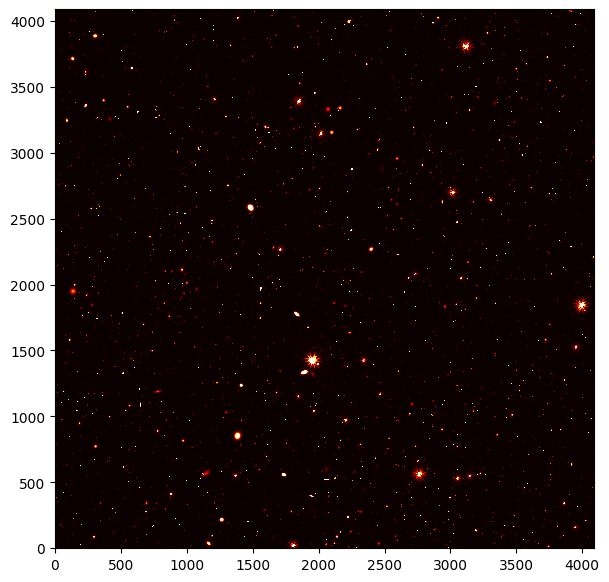

In [9]:
plt.imshow(np.rot90(full_direct), origin="lower", cmap="hot", vmin=0, vmax=5)

Text(0.5, 1.0, 'Grism Image')

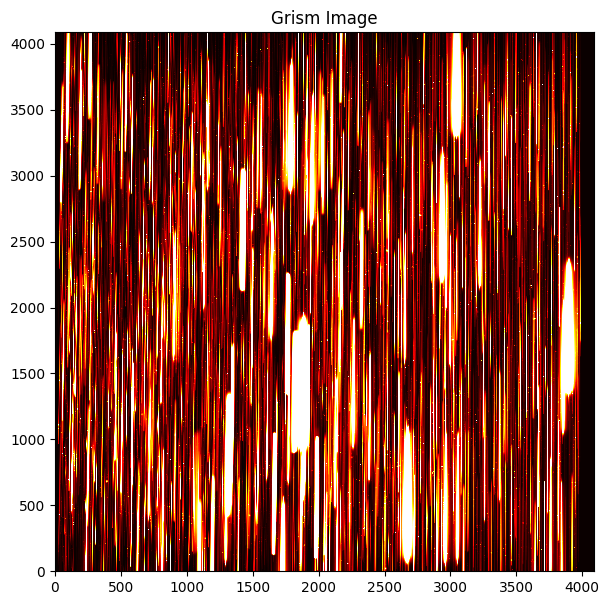

In [10]:
fig, ax = plt.subplots()

upright_img = np.rot90(roman_sim.model[pad:-pad,pad:-pad])
ax.imshow(upright_img, origin='lower', vmin=0, vmax=0.11738539732765789, cmap='hot')
ax.set_title("Grism Image")

# ax.axvline(1624)
# ax.axvline(2624)
# ax.axhline(723)
# ax.axhline(1723)

In [11]:
# Take header info from prepared direct image
file = fits.open(direct_file)
phdu = file[0]
hdr = file[1].header

# Preprare Direct FITS
dir_ihdu = fits.ImageHDU(data=np.rot90(full_direct), header=hdr, name="SCI")
dir_errhdu = fits.ImageHDU(data=zero_data, header=hdr, name="ERR")
dir_dqhdu = fits.ImageHDU(data=zero_data, header=hdr, name="DQ")
direct_hdul = [phdu, dir_ihdu, dir_errhdu, dir_dqhdu]

# Prepare Slitless FITS
slitless_ihdu = fits.ImageHDU(data=upright_img, header=hdr, name="SCI")
slitless_errhdu = fits.ImageHDU(data=zero_data, header=hdr, name="ERR")
slitless_dqhdu = fits.ImageHDU(data=zero_data, header=hdr, name="DQ")
slitless_hdul = [phdu, slitless_ihdu, slitless_errhdu, slitless_dqhdu]

# Save both files
fits.HDUList(direct_hdul).writeto("direct_sim.fits", overwrite=True)
fits.HDUList(slitless_hdul).writeto("slitless_sim.fits", overwrite=True)

file.close()